In [3]:
import glob

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.markers import CARETLEFTBASE, CARETRIGHTBASE

all_files = glob.glob("roll_data/*-hr.csv")
df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)

In [4]:
dfc = df.copy()
for exclude_mod in ["O_NO", "ON_FIRE", "OVERPERFORMING", "UNDERPERFORMING", "GROWTH", "HIGH_PRESSURE", "SINKING_SHIP", "TRAVELING", "CHUNKY", "SMOOTH"]:
    dfc = dfc[~dfc["batter_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["pitcher_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["pitching_team_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["batting_team_mods"].astype(str).str.contains(exclude_mod)]

batter_params = ['batter_buoyancy', 'batter_divinity', 'batter_martyrdom', 'batter_moxie', 'batter_musclitude', 'batter_patheticism', 'batter_thwackability', 'batter_tragicness', 'batter_coldness', 'batter_overpowerment', 'batter_ruthlessness', 'batter_shakespearianism', 'batter_suppression', 'batter_unthwackability', 'batter_base_thirst', 'batter_continuation', 'batter_ground_friction', 'batter_indulgence', 'batter_laserlikeness', 'batter_anticapitalism', 'batter_chasiness', 'batter_omniscience', 'batter_tenaciousness', 'batter_watchfulness', 'batter_pressurization', 'batter_cinnamon']
pitcher_params = ['pitcher_buoyancy', 'pitcher_divinity', 'pitcher_martyrdom', 'pitcher_moxie', 'pitcher_musclitude', 'pitcher_patheticism', 'pitcher_thwackability', 'pitcher_tragicness', 'pitcher_ruthlessness', 'pitcher_overpowerment', 'pitcher_unthwackability', 'pitcher_shakespearianism', 'pitcher_suppression', 'pitcher_coldness', 'pitcher_base_thirst', 'pitcher_continuation', 'pitcher_ground_friction', 'pitcher_indulgence', 'pitcher_laserlikeness', 'pitcher_anticapitalism', 'pitcher_chasiness', 'pitcher_omniscience', 'pitcher_tenaciousness', 'pitcher_watchfulness', 'pitcher_pressurization', 'pitcher_cinnamon']
for attr in batter_params:
    dfc[attr] = dfc[attr] * df['batter_multiplier']
for attr in pitcher_params:
    dfc[attr] = dfc[attr] * df['pitcher_multiplier']

dfc.loc[dfc["pitcher_mods"].astype(str).str.contains("SCATTERED"),"pitcher_vibes"] = 0
dfc.loc[dfc["batter_mods"].astype(str).str.contains("SCATTERED"),"batter_vibes"] = 0

dfc = dfc[dfc["batter_multiplier"] == 1]
dfc = dfc[dfc["pitcher_multiplier"] == 1]


In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm, linear_model

dfc["div_vibes"] = dfc["batter_divinity"] * (1 + 0.2*dfc["batter_vibes"])
dfc["opw_vibes"] = dfc["pitcher_overpowerment"] * (1 + 0.2*dfc["pitcher_vibes"])

X = dfc[["roll", "div_vibes", "opw_vibes", "ballpark_grandiosity", "ballpark_fortification", "ballpark_forwardness"]]
y = dfc['passed']

sc = StandardScaler()
X2 = sc.fit_transform(X)

trainedsvm = svm.LinearSVC(dual=False, C=10000, max_iter=10000, tol=1e-5).fit(X2, y)
predictionsvm = trainedsvm.predict(X2)
confusion_matrix(y,predictionsvm)

array([[4982,    7],
       [   3, 1210]], dtype=int64)

In [6]:
print(len(dfc[~dfc["passed"]]))
print(len(dfc[dfc["passed"]]))

4989
1213


In [7]:
coef = np.true_divide(trainedsvm.coef_, sc.scale_)
coef_scaled = coef / coef[0, 0]
coef_list = coef_scaled.tolist()[0]
sorted(zip(coef_list, X.columns), key=lambda x: abs(x[0]), reverse=True)

[(1.0, 'roll'),
 (-0.1600979987357672, 'div_vibes'),
 (0.07430675279358373, 'opw_vibes'),
 (0.07251278179121047, 'ballpark_grandiosity'),
 (-0.04904088477664352, 'ballpark_forwardness'),
 (0.033225842386439046, 'ballpark_fortification')]

In [17]:
intercept = trainedsvm.intercept_ - np.dot(coef, sc.mean_)
intercept_scaled = intercept / coef[0, 0]
intercept_scaled

array([-0.1464302])

In [18]:
fwd = dfc["ballpark_forwardness"]
obt = dfc["ballpark_obtuseness"]
filth = dfc["ballpark_filthiness"]
grand = dfc["ballpark_grandiosity"]
fort = dfc["ballpark_fortification"]
visc = dfc["ballpark_viscosity"]

div = dfc["batter_divinity"] * (1+0.2*dfc["batter_vibes"])

ruth = dfc["pitcher_ruthlessness"] * (1+0.2*dfc["pitcher_vibes"])
opw = dfc["pitcher_overpowerment"] * (1+0.2*dfc["pitcher_vibes"])

dfc["threshold"] = 0.1464 + 0.16*div - 0.0743*opw - 0.0725*grand + 0.049*fwd - 0.0332*fort

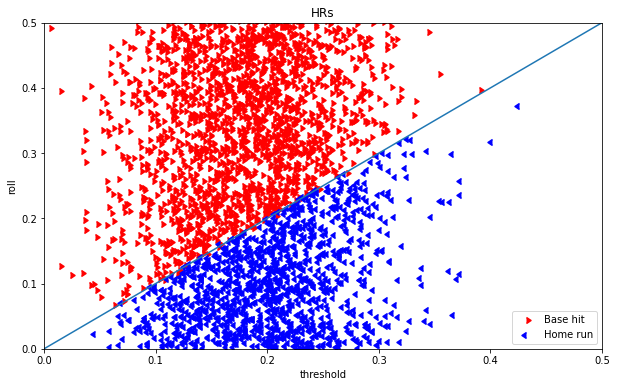

In [19]:
x_val = "threshold"
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.scatter(dfc[~dfc['passed']][x_val], dfc[~dfc['passed']]["roll"], color="red",
           label="Base hit", marker=CARETRIGHTBASE)
ax.scatter(dfc[dfc['passed']][x_val], dfc[dfc['passed']]["roll"], color="blue",
           label="Home run", marker=CARETLEFTBASE)
ax.plot([0, 1], [0, 1])
ax.set_xlabel(x_val)
ax.set_ylabel('roll')
ax.set_title("HRs")
ax.set_xlim([0.0, 0.5])
ax.set_ylim([0.0, 0.5])
ax.legend()

,offset,weather,event_type,batter_multiplier,pitcher_multiplier,roll,threshold,batter_divinity,pitcher_overpowerment,batter_name,pitcher_name,batter_mods,pitcher_mods,batting_team_mods,pitching_team_mods,day,game_id,play_count
5845,-0.003069,18,BaseHit,1.0,1.0,0.203924,0.206993,0.667386,0.251836,Don Elliott,Lars Taylor,NaN,SWIM_BLADDER;TRIPLE_THREAT,LIFE_OF_PARTY;ELECTRIC,BASE_INSTINCTS,43,fac78f6b-8516-437d-b0ff-a2f9a636e8fa,24
9557,-0.002570,18,BaseHit,1.0,1.0,0.115436,0.118006,0.666219,1.269963,Bottles Suljak,Ruslan Greatness,NaN,FRIEND_OF_CROWS,MAINTENANCE_MODE;PARTY_TIME,AFFINITY_FOR_CROWS,93,e9d13610-9821-42f7-933b-927e4f70dd5d,26
8284,-0.000918,7,BaseHit,1.0,1.0,0.269589,0.270507,1.082960,0.290778,Ren Hunter,Adalberto Tosser,NaN,WILD;CREDIT_TO_THE_TEAM,BIRD_SEED,CARCINIZATION;UNHOLEY;PARTY_TIME,86,8ab998f5-0b24-4c1d-80e4-53a40777b927,42
7475,-0.000808,10,BaseHit,1.0,1.0,0.105555,0.106363,0.365675,0.752735,Stew Briggs,Enid Marlow,REPEATING;WANDERER,NaN,NaN,BOTTOM_DWELLER,81,9b198089-d6ef-4aec-b9c2-5196f5b3f251,285
6748,-0.000705,18,BaseHit,1.0,1.0,0.185758,0.186463,0.667386,0.752735,Don Elliott,Enid Marlow,NaN,NaN,LIFE_OF_PARTY;ELECTRIC,BOTTOM_DWELLER,48,04ceb042-439b-4f52-a99d-dc68c0e4388a,72
207,-0.000428,18,BaseHit,1.0,1.0,0.245077,0.245505,1.005673,0.310716,Patel Beyonce,Magi Ruiz,HONEY_ROASTED,NaN,NaN,NaN,7,3395f4ee-baed-4917-a2e6-317bb5b0c38e,115
6374,-0.000365,18,BaseHit,1.0,1.0,0.176176,0.176541,0.619616,0.450527,Silvaire Semiquaver,Mullen Peterson,NaN,NaN,NaN,NaN,46,8f9cde6f-9f38-4bfa-984a-0170d179fec0,55
2996,0.000264,14,HomeRun,1.0,1.0,0.070218,0.069953,0.184577,1.047102,Yusef Puddles,Finn James,NaN,WILD,AFFINITY_FOR_CROWS,CARCINIZATION;UNHOLEY,23,6e2784e8-e253-4c0e-9c42-76846768bcd6,24
2160,0.000397,18,HomeRun,1.0,1.0,0.232623,0.232226,1.054999,0.938392,Goodwin Morin,Caleb Alvarado,EGO1,FRIEND_OF_CROWS,NaN,NaN,17,40ca31c2-1756-47ec-acdb-d0d333948b75,278
505,0.003938,11,HomeRun,1.0,1.0,0.161164,0.157227,0.364071,0.328582,Jan Canberra,Karato Bean,NaN,NaN,UNDERSEA,NaN,8,4066bcc5-c90b-4a44-b1ef-ed77b89c8e2f,324


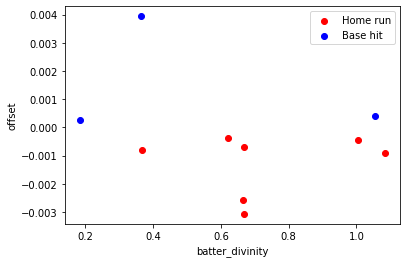

In [21]:
dfc["offset"] = dfc["roll"] - dfc["threshold"]
outliers = dfc[(dfc["passed"] & (dfc["offset"] > 0)) | (~dfc["passed"] & (dfc["offset"] < 0))]

fig, ax = plt.subplots(1)
x_val = "batter_divinity"
y_val = "offset"
ax.scatter(outliers[~outliers['passed']][x_val], outliers[~outliers['passed']][y_val], color="red", label="Home run")
ax.scatter(outliers[outliers['passed']][x_val], outliers[outliers['passed']][y_val], color="blue", label="Base hit")
ax.set_xlabel(x_val)
ax.set_ylabel(y_val)
ax.legend()

table = outliers
table[["offset", "weather", "event_type", "batter_multiplier", "pitcher_multiplier",
       "roll", "threshold",
       "batter_divinity", "pitcher_overpowerment",
       "batter_name", "pitcher_name", "batter_mods", "pitcher_mods",
       "batting_team_mods", "pitching_team_mods", "day",  "game_id", "play_count"]].sort_values('offset')


In [23]:
print(dfc[dfc["passed"]]["roll"].min())
print(dfc[~dfc["passed"]]["roll"].max())

0.0003160323177016
0.999883006776668
